# Transformer 구현

reference : https://wikidocs.net/31379

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 기존 Seq2Seq의 한계

- 인코더 - 디코더 구조로 구성되어져 있는데, 입력 시퀀스를 하나의 Context 벡터로 압축하는 과정에서 이 Context Vector가 소스 문장의 모든 정보를 가지고 있어야 하므로 성능이 저하된다.
- 이를 보정하기 위해서 Attention이 사용되었다. 그런데 Attention을 RNN의 보정을 위한 용도로 쓰는게 아니라 Attention만으로 인코더와 디코더를 만들어보면 어떨까? -> Transformer

## 포지셔널 인코딩

- RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 순차적으로 입력받아서 처리하는 특성으로 인해 각 단어의 위치 정보를 가질 수 있다는 점에 있었다.  
- 그런데 트랜스포머는 RNN을 없앤 것. 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있다.  
- 그래서 각 단어의 임베딩 벡터에 위치 정보들을 더해서 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩이라고 한다.  
- 각 임베딩 벡터에 포지셔널 인코딩 값을 더하면, 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라지게 된다. 즉, 순서 정보가 고려된 임베딩 벡터가 된다.

## 1. PositionalEncoding 구현 코드

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):  # tf.keras.layers.Layer를 상속받는 PositionalEncoding 클래스 정의
    def __init__(self, position, d_model):  # 클래스 생성자
        super(PositionalEncoding, self).__init__()  # 부모 클래스의 init 메소드를 호출하여 초기화해준다.
        self.pos_encoding = self.positional_encoding(position, d_model)  # 생성자 내부에서 positional_encoding 메서드를 호출하여 포지셔널 인코딩 값을 계산하고 pos_encoding에 저장한다.
        
    def get_angles(self, position, i, d_model):  
        # position과 차원에 대한 각도 값 계산. 이때 position이란? 최대 시퀀스 길이를 나타낸다.
        # 이때 i란? 임베딩 벡터 내의 차원의 인덱스를 의미한다. i am a student에서 am의 임베딩 벡터가 d_model의 차원을 가지고 쫘라락 있을텐데, 그 인덱스를 뜻하는게 i이다.
        # d_model은 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미함. 임베딩 벡터의 차원 또한 d_model이며, 각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 차원을 유지 함. 계속 이어서 하니까.
        
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32)) 
        # i가 짝수 인덱스라면 sin을, 홀수 인덱스라면 cos을 씌운다. 
        # i//2인 이유 : i=1이랑 i=2일때는 똑같은 값을 cos에 씌우고 sin에 씌우고의 차이이다.
        # tf.cast로 실수로 만들어주는 이유는 d_model은 임베딩 차원의 수를 나타내는데, 정수로 주어지므로 나눗셈 연산을 위해서 실수 자료형으로 변환해야 한다.
        
        return position * angles  # pos와 곱해준다.
    
    def positional_encoding(self, position, d_model):  # position과 d_model값에 대해서 포지셔널 인코딩 값을 계산한다.
        
        angle_rads = self.get_angles(  # 이전에 정의한 get_angles 메서드 호출한다. position, i, d_model을 인자로 받는다.
                                     
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],  # tf.range(position)을 하면 0부터 position-1까지의 숫자를 생성한다. 근데 데이터 타입은 실수로 하라는 것이다. 
            # tf.newaxis는 새로운 차원을 추가하는 역할을 한다. 그니까 [:, tf.newaxis]를 하게 되면 shape가 (position,)이던 것이 (position, 1)로 바뀌게 된다.
            
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # 얘도 마찬가지로 0부터 d_model-1까지의 숫자를 생성하고 데이터 타입을 실수로 하라는 것이다.
            # 그리고 tf.newaxis를 통해서 축을 하나 추가한다. 앞에다가 추가했으므로 shape가 (d_model,)이던 것이 (1, d_model)이 되는 것이다.
            
            d_model = d_model  # get_angles 메서드의 d_model 인자에 d_model 값 전달
        )
        
        # 근데 도대체 newaxis를 왜 해주는거냐? 얘를 들어서 position은 4, d_model은 512라고 해보자. 
        # position은 4니까 (4,1)의 shape가 되고, i는 (1, 512)가 된다. 그럼 결과적으로 angle_rads는 shape가 (position, d_model)인 (4, 512) 2D 텐서가 된다. 왜? get_angels는 return값이 position * angles이므로
        
        
        
        sines = tf.math.sin(angle_rads[:, 0::2])  # 배열의 짝수 인덱스(2i)에 사인 함수 적용한 것을 sines에 담는다, 이때 angle_rads는 (position, d_model)의 shape를 가진다.
        
        cosines = tf.math.cos(angle_rads[:, 1::2])  # 배열의 홀수 인덱스(2i+1)에 코사인 함수 적용한 것을 cosines에 담는다.
        
        angle_rads = np.zeros(angle_rads.shape) # angle_rads의 shape를 가진 새로운 배열을 초기화시킨다
        angle_rads[:, 0::2] = sines # 사인 및 코사인 값을 해당 위치에 할당한다
        angle_rads[:, 1::2] = cosines
        # 의문 : 그냥 angle_rads[:, 0::2] = tf.math.sin(angle_rads[:, 0::2]) 하면 되는 것 아닌가? 중간 변수를 사용한 이유가 뭘까?
        
        
        
        pos_encoding = tf.constant(angle_rads)  # Tensorflow 연산을 수행하기 위해 angle_rads를 Tensor로 변환한다. 왜?  angle_rads = np.zeros(angle_rads.shape) 이 코드에서 angle_rads는 numpy array가 되어서
        pos_encoding = pos_encoding[tf.newaxis, ...]  # tf.newaxis는 새 차원 추가하는 것, ...는 텐서의 나머지 모든 차원을 그대로 유지하는 것.
        # 즉 pos_encoding의 shape는 (1, position, d_model)이 된다. 왜 이런 연산을 하냐? 아직 모르겠음. 이후에 써먹는건가? 아마도 batch size 연산때문에 앞에 차원 추가를 앞에 한 듯하다
        
        print(pos_encoding.shape)  # pos_encoding의 shape를 출력한다. (1, position, d_model)이 될 것
        
        return tf.cast(pos_encoding, tf.float32)  # float32로 캐스팅 해준 결과를 return한다.
    
    def call(self, inputs): # call 메서드는 Tensorflow의 Layer 클래스에서 주로 사용하는 메서드임. 이 메서드가 호출될 때 레이어의 주요 계산이 수행된다고 함.
        # inputs은 call 메서드의 입력, 즉 Transformer 모델에서 임베딩된 텍스트 텐서가 전달되는 것이다. 우리는 이 텍스트 텐서에 Positional Encoding을 더해줄 것이다.
        # inputs텐서의 크기는 일반적으로 (batch_size, sequence_length, d_model)
        
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
        # inputs과 포지셔닝 인코딩 값을 더해주고 반환하는 것
        # tf.shape(inputs)[1]로 입력된 텐서의 시퀀스 길이를 구한다. 그리고 pos_encoding에서 그만큼을 똑 떼어와서 계산한다.
    
    

50 x 128의 크기를 가지는 포지셔널 인코딩 행렬을 시각화해보자

(1, 50, 128)


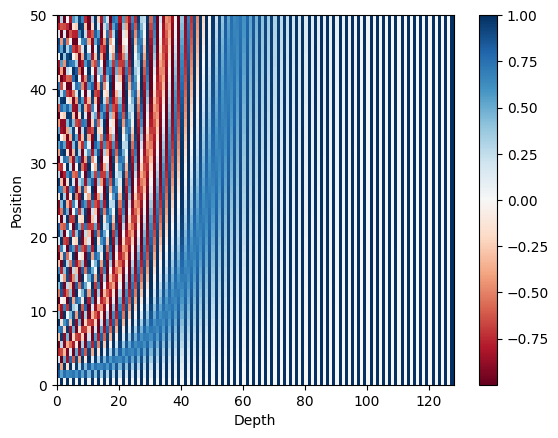

In [3]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolor(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')  # [0]을 통해서 첫 번째 차원인 1은 제거해주고 2D로 나타내주는 것.
plt.xlabel('Depth')
plt.xlim((0,128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

cos, sin 씌워줘서 -1 ~ 1 사이의 값을 가지는 것을 볼 수 있다. 이 포지셔널 인코딩 벡터를 원래 input(단어 임베딩 벡터)에다가 더해줌으로써 순서 정보를 추가해주는 것이다.

## Self - Attention

- 셀프 어텐션은 인코더의 초기 입력인 d_model의 차원을 가지는 단어 벡터들을 사용하여 수행하는 것이 아니라, 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거친다.
- 이 때 이 Q벡터, K벡터, V벡터들은 초기 입력인 d_model의 차원을 가지는 단어벡터들보다 더 작은 차원을 가진다.
- 원 논문에서는 d_model = 512의 차원을 가졌던 각 단어벡터들을 64의 차원을 가지는 Q,K,V 벡터로 변환하였다.

- 64라는 값은 하이퍼파라미터인 num_heads로 인해 결정되는데, d_model / num_heads 값을 Q,K,V 벡터의 차원으로 결정한다. 논문에서는 num_heads = 8이다.
- 예를 들어서 i am a student의 예문 중 student라는 단어 벡터를 Q,K,V의 벡터로 변환하는 과정을 봐보자

- Q,K,V 벡터는 단어 벡터에 각 가중치 행렬을 곱함으로서 완성된다. 이 가중치 행렬은 (d_model, d_model/num_heads)의 크기를 가진다.
- 이 가중치 행렬은 훈련과정에서 학습된다.
- 즉, 논문과 같이 d_model = 512이고 num_heads = 8이라면, 각 벡터에 3개의 서로 다른 가중치 행렬을 곱하고 64의 크기를 가지는 Q,K,V 벡터를 얻어낸다.
- 모든 단어 벡터(i, am, a, student)에 위와 같은 과정을 거치면 i, am, a, student는 각각의 Q,K,V 벡터를 얻는다. 

## Scaled dot-product Attention

- Q, K, V 벡터를 얻었다. 각 Q벡터는 모든 K벡터에 대해서 어텐션 스코어를 구하고, 어텐션 분포를 구한 뒤에 이를 사용하여 모든 V벡터와 가중합하여 어텐션 값(Attention Value)을 구하게 된다.
- 그리고 이를 모든 Q벡터에 대해서 반복한다.
- 이 때 어텐션 스코어를 구할 때 score(q,k) = (q*k)/루트n 을 사용한다. 

- 예를 들어서 i am a student에서 i에 대한 Q벡터를 기준으로 설명하자면, (이 과정은 am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 거친다)
- Q_i는 K_i, K_am, K_a, K_student와 각각 곱해진 후, 나온 값에 루트d_k로 나눠준다. 이것이 어텐션 스코어가 된다. 이 어텐션 스코어는 단어 i가 단어 i, am, a, student와 얼마나 연관되어 있는지를 보여주는 수치이다.
- 이 때 d_k는 d_model/num_heads 이므로 여기서는 64이고, 루트를 씌우면 8이다.
- 이 어텐션 스코어에 소프트맥스 함수를 때려서 어텐션 분포를 구한 후, 각 V벡터와 가중합하여 어텐션 값(Attention Value)를 구한다.

- 이를 단어  i에 대한 어텐션 값, 또는 단어 i에 대한 context vector라고도 할 수 있다. am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 반복하여 각각에 대한 어텐션 값을 구한다.
- 굳이 이렇게 각 Q벡터마다 일일히 따로 연산할 필요가 있을까?

##### 행렬 연산으로 일괄 처리하기가 가능하다.

- 위의 설명은 이해를 돕기 위해서 벡터 연산으로 한것이고, 실제로는 행렬 연산으로 구현된다.
- 각 단어벡터마다 일일히 가중치 행렬을 곱하는 것이 아니라, 문장 행렬에 가중치 행렬을 곱하여 Q행렬, K행렬, V행렬을 구한다.  

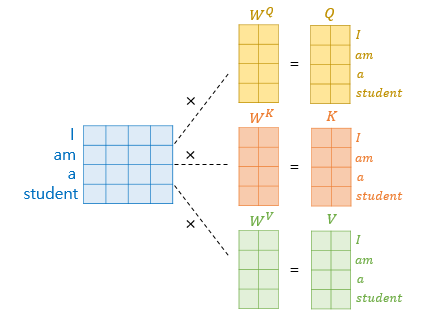

- 행렬 연산을 통해서 어텐션 스코어를 구하려면, Q행렬을 K전치 행렬과 곱해주면 된다. 그러면 각가의 단어의 Q벡터와 K벡터의 내적이 각 행렬의 원소가 되는 행렬이 결과로 나온다.  

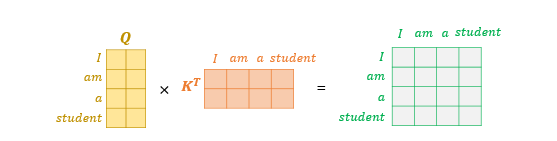

- 위 그림의 결과 행렬값에 전체적으로 루트d_k를 나눠주면 이는 각 행과 열이 어텐션 스코어값을 가지는 행렬이 된다.
- 예를 들어, i행과 student 열의 값은 i의 Q벡터와 student의 K벡터의 어텐션 스코어 값이다.
- 위 행렬을 어텐션 스코어 행렬이라고 하자. 이를 구했다면 어텐션 분포를 구하고, 이를 사용하여 모든 단어에 대한 어텐션 값을 구하는 일이다.  

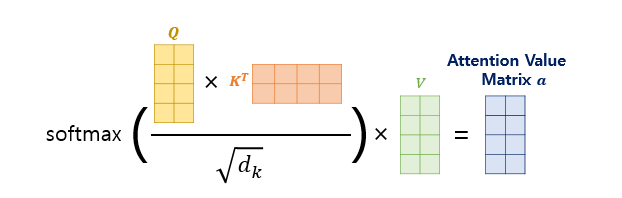

- 이는 어텐션 스코어 행렬에 소프트 맥스 함수를 사용하고, V행렬을 곱하는 것으로 해결된다. 이렇게 되면 각 단어의 어텐션 값을 모두 가지는 어텐션 값 행렬이 결과로 나온다.

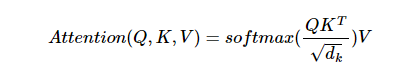

### shape 정리

- 입력 문장의 길이 : seq_len, 문장 행렬의 크기 : (seq_len, d_model)  

- 여기에 3개의 가중치 행렬을 곱해서 Q,K,V 행렬을 만들어야 한다. 

- Q, K 행렬의 크기 (seq_len, d_k)
- V 행렬의 크기 (seq_len, d_v)
- W_Q와 W_K는 (d_model, d_k)
- W_v는 (d_model, d_v)
- 이 논문에서는 d_k = d_v = d_model/num_heads
- 결과적으로 어텐션 값 a의 크기는 (seq_len, d_v)이다.

## 2. 스케일드 닷-프로덕트 어텐션 구현 코드

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)
    
    
    # Q와 K의 곱. 어텐션 스코어 행렬
    matmul_qk = tf.matmul(query, key, transpose_b=True) 
    
    # 스케일링 : d_k의 루트 값으로 나눠준다
    depth = tf.cast(tf.shape(key)[-1], tf.float32)  # tf.shape(key)[-1]가 의미하는 것은 d_model/num_heads로 d_k이다.
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)  # 이 내용은 이후에 다룸
        
    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis = -1)
    
    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)
    
    return output, attention_weights

- Q행렬과 K행렬을 전치한 행렬을 곱하고 루트d_k로 나눠줘서 어텐션 스코어 행렬을 구한다.
- 그 후 소프트맥스를 때려서 어텐션 분포 행렬을 구한다.
- 그 후 V행렬과 곱해서 어텐션 값 행렬 a를 구한다.

In [8]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

쿼리에 해당하는 temp_q의 값 [0, 10, 0]은 Key에 해당하는 temp_K의 두 번째 값과 일치한다는 것 주목

In [9]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


- 쿼리는 4개의 키 값 중 두번째 값과 일치하므로 어텐션 분포는 [0, 1, 0, 0]의 값을 가진다
- 결과적으로 Value의 두 번째 값인 [10,0]이 출력된다

In [11]:
# 쿼리의 값만 다른 값으로 바꿔보고 함수 실행해본다

temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


- 쿼리의 값은 키의 세번째 값과 네번째 값 두 개의 값과 모두 유사하다는 의미에서 어텐션 분포는 [0, 0, 0.5, 0.5]의 값을 가진다.
- 어텐션 값 [550, 5.5]는 Value의 세 번째 값에 0.5를 곱한 값과 네 번째 값에 0.5를 곱한 값의 원소별 합이다

In [12]:
# 하나가 아닌 3개의 쿼리 값을 함수의 입력으로 사용해본다

temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## 멀티 헤드 어텐션

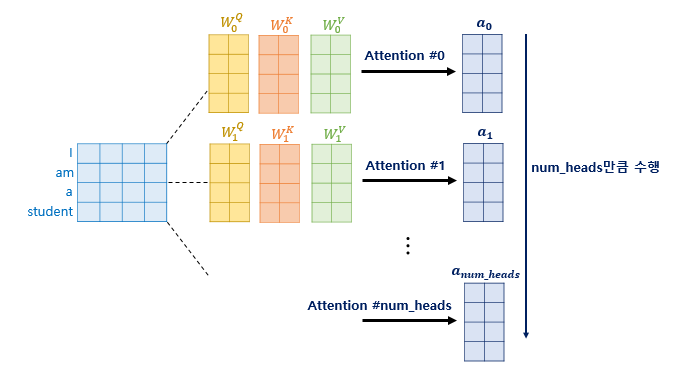

- d_model의 차원을 num_heads개로 나누어 d_model/num_heads의 차원을 가지는 Q,K,V에 대해서 num_heads개의 병렬 어텐션을 수행한다.
- 논문에서는 num_heads = 8로 지정했고, 8개의 병렬 어텐션이 이뤄지게 된다.
- 이때 각각의 어텐션 값 행렬을 어텐션 헤드라고 부른다. 이 때 가중치 행렬 W_Q, W_K, W_V의 값을 8개의 어텐션 헤드마다 전부 다르다.

- 병렬 어텐션으로 얻는 효과? 다른 시각으로 정보를 수집하겠다는 것이다. 예문 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.'를 봐보자
- 단어 그것(it)이 쿼리였다고 해보자, it에 대한 Q벡터로부터 다른 단어와의 연관도를 구하였을 때 첫 번째 어텐션 헤드는 it과 animal의 연관도를 높게 본다면,
- 두 번째 어텐션 헤드는 그것과 tired의 연관도를 높게 볼 수 있다. 각 어텐션 헤드는 전부 다른 시각에서 보고있기 떄문이다.

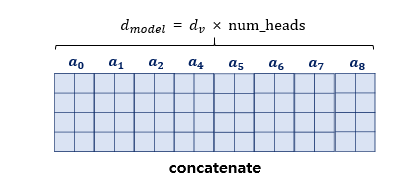

- 병렬 어텐션을 모두 수행했다면 모든 어텐션 헤드를 연결(concatenate)한다. 이 어텐션 헤드 행렬의 크기는 (seq_len, d_model)이 된다.

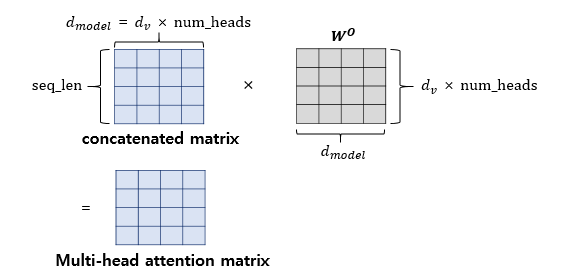

- 어텐션 헤드를 모두 연결한 행렬은 또 다른 가중치 행렬 W^o를 곱하게 되는데, 이렇게 나온 결과 행렬이 멀티헤드 어텐션의 최종 결과물이다.
- 이 때 결과물인 멀티-헤드 어텐션 행렬은 인코더의 입력이었던 문장 행렬의 (seq_len, d_model) 크기와 동일하다.

즉, 인코더의 첫 번째 서브층인 멀티-헤드 어텐션 단계를 끝마쳤을 때, 인코더의 입력으로 들어왔던 행렬의 크기가 아직 유지되고 있다는 것이다.

첫 번째 서브층인 멀티-헤드 어텐션과 두 번째 서브층인 포지션 와이즈 피드 포워드 신경망을 지나면서 인코더의 입력으로 들어올 때의 행렬의 크기는 계속 유지되어야 한다.  

트랜스포머는 동일한 구조의 인코더를 쌓은 구조로, 논문에서는 인코더가 6개이다. 인코더에서의 입력의 크기가 출력에서도 동일 크기로 계속 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있다.

## 3. 멀티 헤드 어텐션 코드 구현

멀티 헤드 어텐션에서는 